Original shape: (36, 246)
Filtered shape (tests and characteristics with >=10 overlaps): (10, 17)


/lab/solexa_sun/lab_members/yancui/miniconda3/envs/fm/lib/python3.11/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


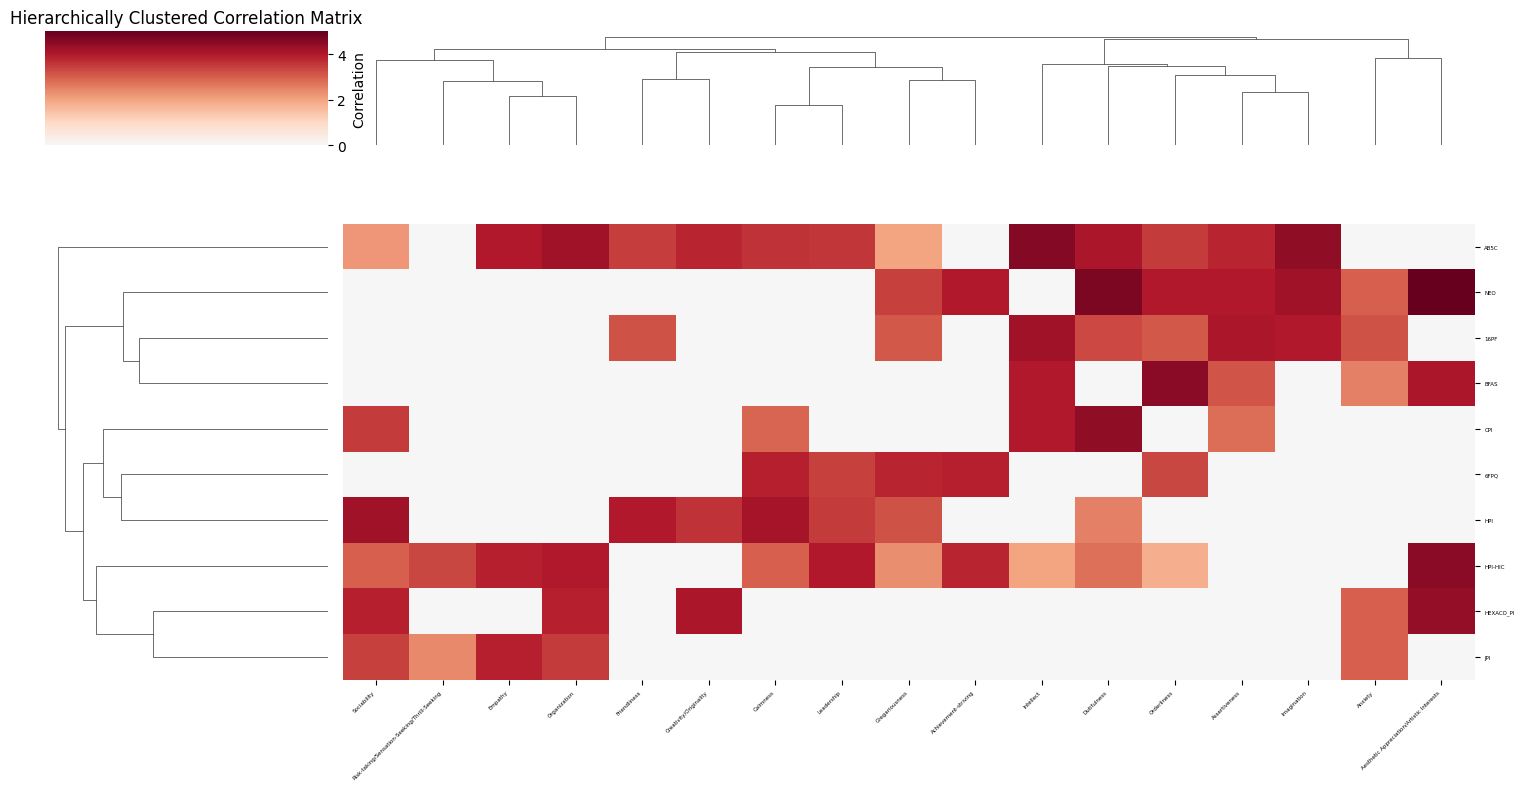

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

df = pd.read_csv('experiment_scores.csv', index_col=0)

# Handle NaN values by filling them with 0
df_clean = df.fillna(0)

# Count non-NaN values for each row and column
 # Count non-NaN per row (test)
col_counts = df.notna().sum(axis=0)  # Count non-NaN per column (characteristic)

# Filter columns with at least 10 non-NaN values
cols_to_keep = col_counts[col_counts >= 5].index
df_filtered_cols = df[cols_to_keep]

row_counts = df_filtered_cols.notna().sum(axis=1) 

# Filter rows with at least 10 non-NaN values
df_filtered = df_filtered_cols[row_counts >= 5]

# For each filtered row, keep only columns that are not NaN
df_shared = pd.DataFrame()
for idx in df_filtered.index:
    row = df_filtered.loc[idx]
    shared_cols = row[row.notna()].index
    df_shared = pd.concat([df_shared, df.loc[[idx], shared_cols]], axis=0)

print(f"Original shape: {df.shape}")
print(f"Filtered shape (tests and characteristics with >=10 overlaps): {df_shared.shape}")


df_clean = df_shared.fillna(0)

# Create a clustermap with hierarchical clustering # Increased figure size further
# Set higher DPI for better resolution
cluster_map = sns.clustermap(df_clean,
                           cmap='RdBu_r', 
                           center=0,
                           annot=False,
                           fmt='.2f',
                           square=True,
                           cbar_kws={'label': 'Correlation'},
                           xticklabels=True,
                           yticklabels=True,
                           figsize=(15, 8))  # Set clustermap size directly

# Rotate x-axis labels for better readability
plt.setp(cluster_map.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=4)  # Increased font size
plt.setp(cluster_map.ax_heatmap.get_yticklabels(), rotation=0, fontsize=4)

plt.title('Hierarchically Clustered Correlation Matrix')
plt.tight_layout()
plt.savefig('clustermap.pdf', format='pdf', bbox_inches='tight')  # Save high-res figure
plt.show()


In [5]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
import pingouin as pg

data = df_shared.T

def concordance_correlation_coefficient(x, y):
    # Remove pairs where either x or y is NaN
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Check if we have enough data points after removing NaN
    if len(x_clean) < 2:
        return np.nan
        
    mean_x, mean_y = np.mean(x_clean), np.mean(y_clean)
    var_x, var_y = np.var(x_clean, ddof=1), np.var(y_clean, ddof=1)
    cov_xy = np.cov(x_clean, y_clean, ddof=1)[0, 1]
    pearson_corr = cov_xy / (np.sqrt(var_x) * np.sqrt(var_y))
    ccc = (2 * pearson_corr * np.sqrt(var_x) * np.sqrt(var_y)) / (var_x + var_y + (mean_x - mean_y)**2)
    return ccc

# 1. Average Pairwise CCC (manual)
characteristics = data.columns
ccc_values = []
for i in range(len(characteristics)):
    for j in range(i+1, len(characteristics)):
        ccc = concordance_correlation_coefficient(data[characteristics[i]], data[characteristics[j]])
        if not np.isnan(ccc):  # Only include non-NaN values
            ccc_values.append(ccc)
avg_ccc = np.mean(ccc_values) if ccc_values else np.nan

# 2. Average Pairwise PCC
# Use pairwise complete observations
corr_matrix = data.corr(method='pearson')
# Get upper triangle excluding diagonal
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_values = corr_matrix.where(mask).values
avg_pcc = np.nanmean(corr_values)  # Use nanmean to handle NaN values

# Calculate average pairwise Spearman correlation
spearman_matrix = data.corr(method='spearman')
# Get upper triangle excluding diagonal, same as for Pearson
spearman_values = spearman_matrix.where(mask).values 
avg_spearman = np.nanmean(spearman_values)  # Use nanmean to handle NaN values


# 3. PCA on Correlation Matrix
# Handle NaN values in correlation matrix before PCA
corr_matrix_clean = corr_matrix.fillna(corr_matrix.mean())  # Fill NaN with mean
pca = PCA()
pca.fit(corr_matrix_clean)
explained_variance_pc1 = pca.explained_variance_ratio_[0]

# Output
print(f"Average Pairwise CCC: {avg_ccc}")
print(f"Average Pairwise PCC: {avg_pcc}")
print(f"Average Pairwise Spearman: {avg_spearman}")
print(f"Variance Explained by PC1 (PCA): {explained_variance_pc1}")

Average Pairwise CCC: 0.14708886072919108
Average Pairwise PCC: 0.13621916426954314
Average Pairwise Spearman: 0.2085103710513218
Variance Explained by PC1 (PCA): 0.5168420517206707


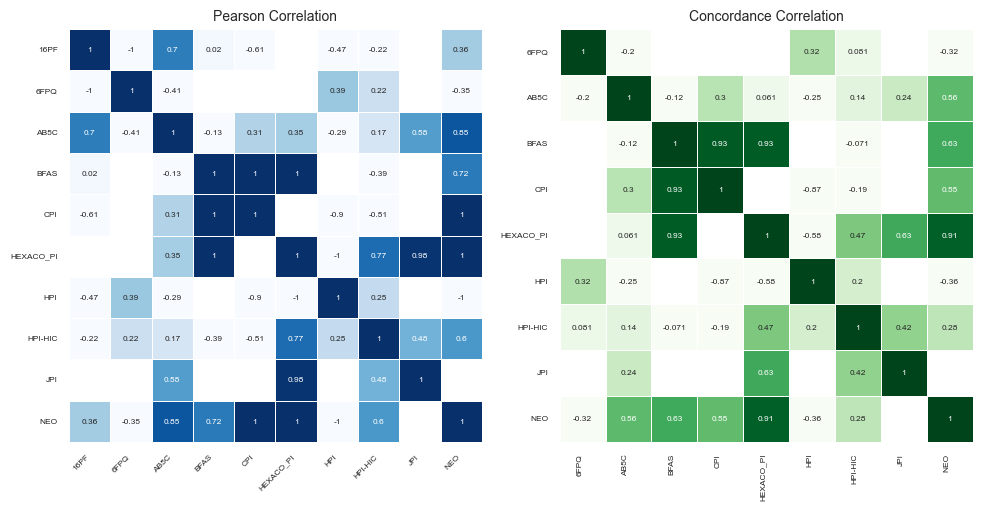

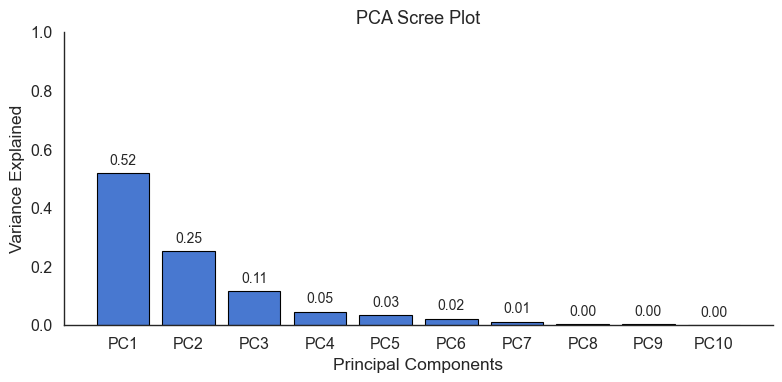

In [7]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Set a cleaner style with soft muted colors
sns.set(style='white', context='paper', font_scale=1.3)
muted_colors = sns.color_palette("muted")

# Calculate CCC matrix
test_cols = data.columns[1:]
ccc_matrix = pd.DataFrame(np.zeros((len(test_cols), len(test_cols))), columns=test_cols, index=test_cols)
for i in range(len(test_cols)):
    for j in range(len(test_cols)):
        ccc = concordance_correlation_coefficient(data[test_cols[i]], data[test_cols[j]])
        ccc_matrix.iloc[i,j] = ccc

# Calculate PCC matrix
corr_matrix = data.corr(method='pearson')

# 1. Correlation Matrix Heatmaps (PCC and CCC side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=0, vmax=1,
            cbar_kws={'label': 'Pearson Correlation'}, square=True, 
            linewidths=0.5, linecolor='white', ax=ax1, cbar=False, annot_kws={'size': 6})
ax1.set_title('Pearson Correlation', fontsize=10)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=6)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=6)

sns.heatmap(ccc_matrix, annot=True, cmap='Greens', vmin=0, vmax=1,
            cbar_kws={'label': 'Concordance Correlation'}, square=True,
            linewidths=0.5, linecolor='white', ax=ax2, cbar=False, annot_kws={'size': 6})
ax2.set_title('Concordance Correlation', fontsize=10)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha='right', fontsize=6)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=6)

plt.tight_layout()
plt.show()

# 2. PCA Scree Plot (Muted color)
corr_matrix_clean = corr_matrix.fillna(corr_matrix.mean()) 
pca = PCA()
pca.fit(corr_matrix_clean)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 4))
bars = plt.bar(range(1, len(explained_variance)+1), explained_variance, 
               color=muted_colors[0], edgecolor='black')
plt.ylabel('Variance Explained')
plt.xlabel('Principal Components')
plt.title('PCA Scree Plot', fontsize=13)
plt.xticks(range(1, len(explained_variance)+1), [f'PC{i}' for i in range(1, len(explained_variance)+1)])
plt.ylim(0, 1)
for bar, var in zip(bars, explained_variance):
    plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height()+0.02, f'{var:.2f}', ha='center', va='bottom', fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()
